In [56]:
import torch.nn.functional as F 
import torchvision 
from torchvision.transforms.functional import to_pil_image 
import torch 
import matplotlib.pyplot as plt 

In [57]:
device = torch.device("mps") 

In [58]:
def beta_scheduler(timesteps, start = 0.0001, end = 0.02): 
    return torch.linspace(start, end, timesteps) 

In [59]:
def get_index(t, vals, x_shape): 
    b_size = t.shape[0] 
    out = vals.gather(-1, t.to(vals.device).to(torch.int64)) 
    
    return out.reshape(b_size, *((1,) * (len(x_shape) -1))).to(device) 

In [60]:
def forward_diffusion(x_0, t, device = "cpu"): 
    noise = torch.randn_like(x_0) 
    sqrt_alphas_prod_t = get_index(t, sqrt_alphas_prod, x_0.shape) 
    sqrt_one_minus_alphas_prod_t = get_index(t, sqrt_one_minus_alphas_prod, x_0.shape) 
    
    return sqrt_alphas_prod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_prod_t.to(device) * noise.to(device), noise 

In [61]:
T = 128 
betas = beta_scheduler(timesteps = T) 

In [62]:
alphas = 1. - betas 
alphas_prod = torch.cumprod(alphas, 0) 
alphas_prod_prev = F.pad(alphas_prod[:-1], (1, 0), value = 1.) 
sqrt_recip_alphas = torch.sqrt(1. / alphas_prod) 
sqrt_alphas_prod = torch.sqrt(alphas_prod) 
sqrt_one_minus_alphas_prod  = torch.sqrt(1. - alphas_prod) 
posterior_variance = betas * ((1. - alphas_prod_prev) / (1 - alphas_prod)) 

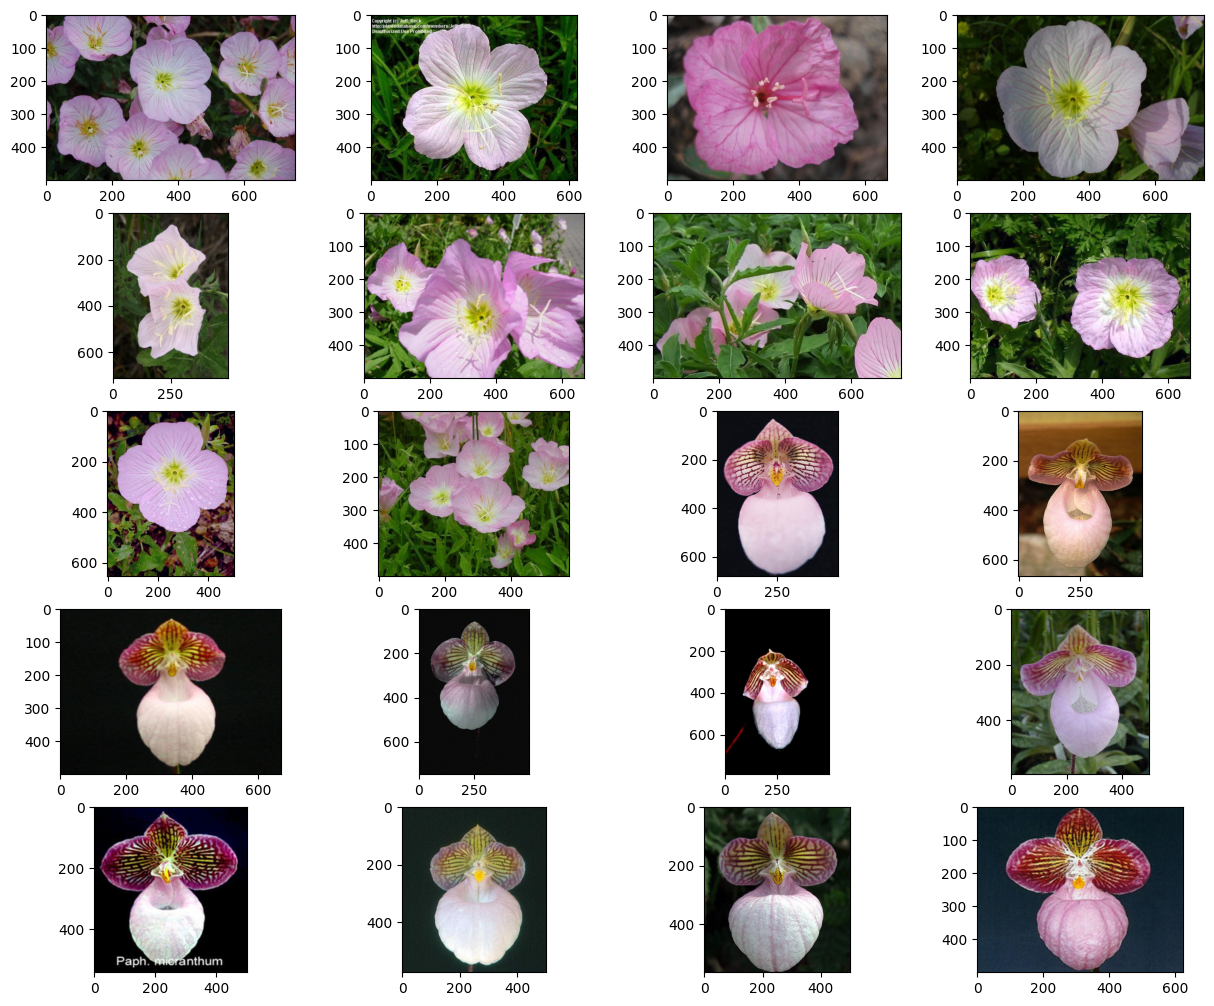

In [63]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.Flowers102(root=".", download=True)
show_images(data)

In [64]:
def show_tensor(tensor): 
    pillow = to_pil_image(tensor) 
    pillow.show() 

In [65]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True,
                                              transform=data_transform)

    test = torchvision.datasets.Flowers102(root=".", download=True,
                                             transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

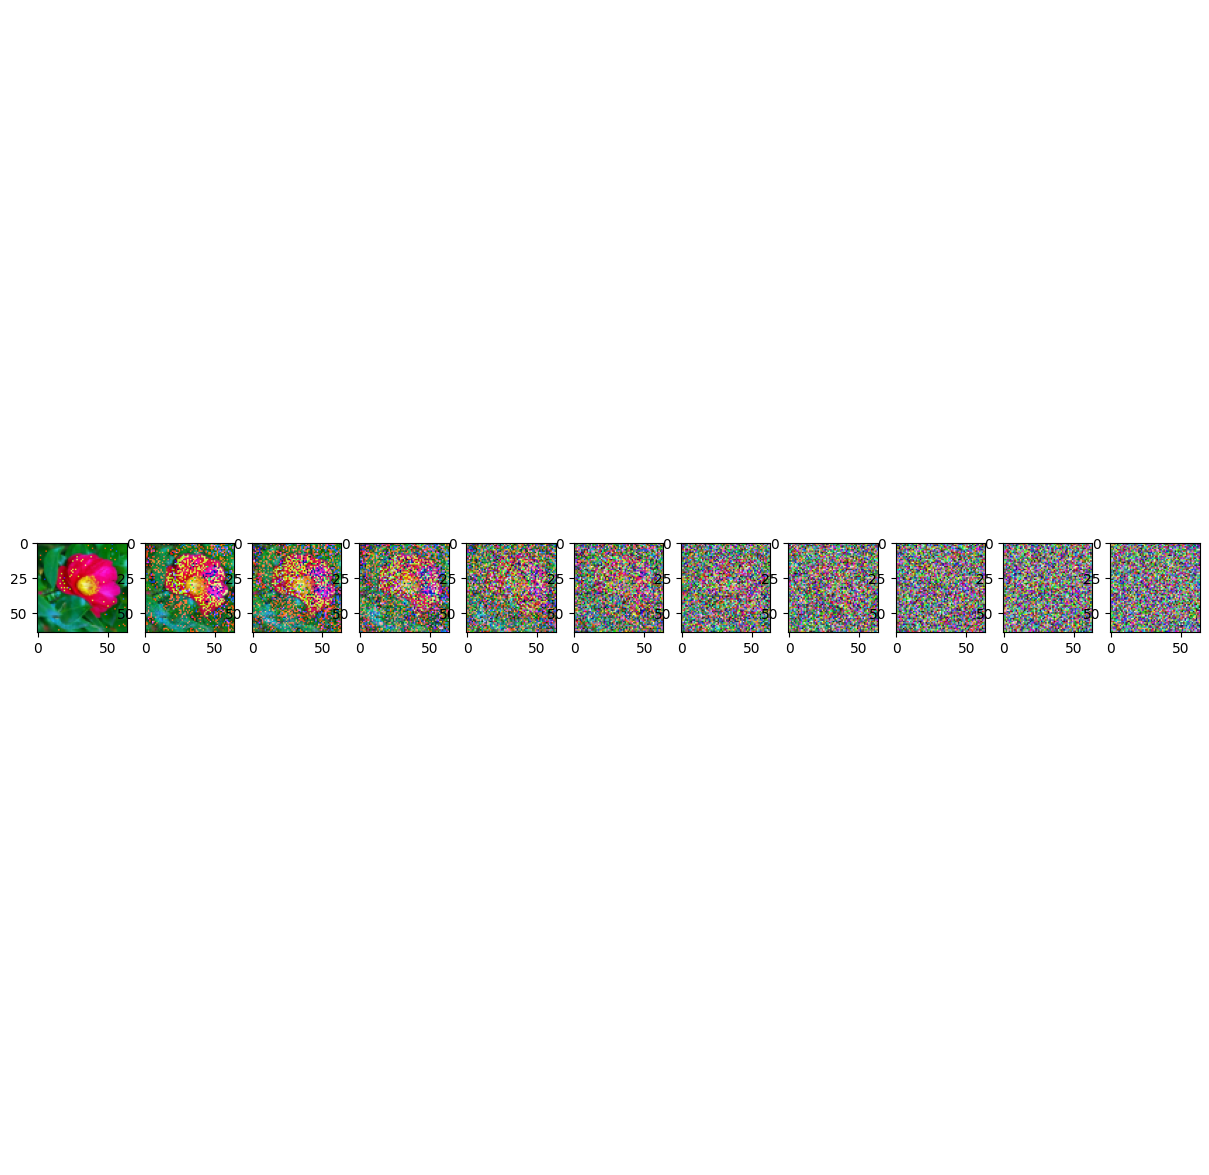

In [66]:
# Simulate forward diffusion 
image = next(iter(dataloader))[0]
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images) 

for idx in range(0, T, stepsize):   
    t = torch.Tensor([idx]).to(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion(image, t)
    show_tensor_image(img) 

In [67]:
import torch.nn as nn 
import math 

In [68]:
class UBlock(nn.Module): 
    def __init__(self, in_ch, out_ch, time_emb_dim, up = False): 
        super().__init__() 
        
        self.time_mlp = nn.Linear(time_emb_dim, out_ch) 
        
        if up: 
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding = 1) 
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1) 
        else: 
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1) 
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1) 
            
        self.conv2 = nn.Conv2d(out_ch, out_ch,3, padding = 1) 
        self.bn1 = nn.BatchNorm2d(out_ch) 
        self.bn2 = nn.BatchNorm2d(out_ch) 
        self.relu = nn.ReLU() 
        
    def forward(self, x, t, ): 
        a = self.bn1(self.relu(self.conv1(x))) 
        time_emb = self.relu(self.time_mlp(t)) 
        time_emb = time_emb[(..., ) + (None, ) * 2] 
        
        a_emb = a + time_emb 
        b = self.bn2(self.relu(self.conv2(a_emb))) 
        return self.transform(b) 


In [69]:
class SinusoidoPositionalEmbedding(nn.Module): 
    def __init__(self, dim): 
        super().__init__() 
        self.dim = dim 
        
    def forward(self, time): 
        
        device = time.device 
        half_dim = self.dim // 2 
        
        embeddings = math.log(10000) / (half_dim - 1) 
        embeddings = torch.exp(torch.arange(half_dim, device = device) * -embeddings) 
        embeddings = time[:, None] * embeddings[None, :] 
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), -1) 
        
        return embeddings 

In [70]:
class UNet(nn.Module): 
    def __init__(self): 
        super().__init__() 
        
        image_ch = 3
        out_ch = 3 
        time_emb_dim = 32 
        down_chs = (64, 128, 256, 512, 1024) 
        up_chs = (1024, 512, 256, 128, 64) 
        
        self.time_mlp = nn.Sequential( 
            SinusoidoPositionalEmbedding(time_emb_dim), 
            nn.Linear(time_emb_dim, time_emb_dim), 
            nn.ReLU(), 
        )
        
        self.init = nn.Conv2d(image_ch, down_chs[0], 3, padding = 1) 
        self.down = nn.ModuleList([UBlock(down_chs[i], down_chs[i + 1], time_emb_dim) for i in range(len(down_chs) - 1)]) 
        self.up = nn.ModuleList([UBlock(up_chs[i], up_chs[i + 1], time_emb_dim, True) for i in range(len(up_chs) - 1)]) 
        self.out = nn.Conv2d(up_chs[-1], out_ch, 1) 
        
    def forward(self, x, timestep): 
        t = self.time_mlp(timestep) 
        x = self.init(x) 
        resids = [] 
        
        for l in self.down: 
            x = l(x, t) 
            resids.append(x) 
            
        for l in self.up: 
            resid = resids.pop() 
            x = torch.cat((x, resid), 1) 
            x = l(x, t) 
        
        return self.out(x) 

In [71]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model 

Num params:  62438883


UNet(
  (time_mlp): Sequential(
    (0): SinusoidoPositionalEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (init): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): UBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): UBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(2

In [72]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred) 

In [73]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index(betas, t, x.shape)
    sqrt_one_minus_alphas_prod_t = get_index(
        sqrt_one_minus_alphas_prod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_prod_t
    )
    posterior_variance_t = get_index(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize))
            show_tensor_image(img.detach().cpu())
    plt.show()

In [74]:
from torch.optim import Adam

device = 'mps'
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long() 
        loss = get_loss(model, batch[0].to(device), t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ") 

Epoch 0 | step 000 Loss: 0.8108040690422058 


KeyboardInterrupt: 

In [ ]:
def evaluate(): 
    with torch.no_grad(): 
        t = torch.randint(1, T, (BATCH_SIZE, ), device = device).long()  
        input_noise = torch.randn(1, 3, 64, 64, device = device) 
        output = model(input_noise, t)[0] 
        show_tensor(output) 

evaluate() 